# Evolution of actors careers post-blockbuster in the film industry
How does a significant box office success impact an actor's subsequent choices and overall career path ?

##  Context

Analyze career trajectories of actors following their roles in high-grossing films using the CMU Movie Dataset

More specifically, explore the following research questions: 
- Does a high-grossing film consistently lead to **continued box office success** for its actors in their subsequent films?
- Is there a noticeable **change in genre or type of characters** portrayed by actors after a significant hit?
- What are the long-term career impacts on actors who have starred in blockbuster hits?

In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Observational study

In [ ]:
balanced_actors = balanced_df['name_actor']

df_movies_balanced = df_prepared[df_prepared['name_actor'].isin(balanced_actors)]

In [ ]:
df_movies_balanced.columns

Index(['wikiID', 'movieID', 'releaseDate', 'charactName', 'birth', 'gender',
       'height', 'ethnicity', 'name_actor', 'age', 'charActID', 'charID',
       'actID', 'name_movie', 'revenue', 'runtime', 'languages', 'countries',
       'genres', 'year', 'averageRating', 'success', 'big_hit_actor',
       'age_at_peak', 'year_of_peak', 'is_big_hit', 'year_first_big_hit',
       'movie_count', 'movie_count_before_hit'],
      dtype='object')

In [ ]:
df_movies_balanced['releaseDate'].isna().sum()

0

Now, we want to compare the carrer longevity

In [ ]:
# Convert releaseDate to DateTime
df_movies_balanced['releaseDate'] = pd.to_datetime(df_movies_balanced['releaseDate'], errors='coerce')

# Calculate Last and First Apparence
career_start = df_movies_balanced.groupby('name_actor')['releaseDate'].min()
career_end = df_movies_balanced.groupby('name_actor')['releaseDate'].max()

career_duration = (career_end - career_start).dt.days / 365.25  # Convert days to years
career_duration_df = career_duration.reset_index()
career_duration_df.rename(columns={'releaseDate': 'career_length_in_years'}, inplace=True)


/var/folders/f0/cfcxfzqn0nv2yms8q65vtvc80000gn/T/ipykernel_54193/4040368507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_balanced['releaseDate'] = pd.to_datetime(df_movies_balanced['releaseDate'], errors='coerce')


In [ ]:
carrer_longevity_df = pd.merge(df_movies_balanced, career_duration_df, on='name_actor')



In [ ]:
# Analysis
treatment_group = carrer_longevity_df[carrer_longevity_df['big_hit_actor'] == True]
control_group = carrer_longevity_df[carrer_longevity_df['big_hit_actor'] == False]

mean_career_length_treatment = treatment_group['career_length_in_years'].mean()
mean_career_length_control = control_group['career_length_in_years'].mean()

print(f'The mean carrer longevity of actors that played in a big hit is: {mean_career_length_treatment} (treatement group)')
print(f'The mean carrer longevity of actors that did not play in a big hit is: {mean_career_length_control} (control group)')


The mean carrer longevity of actors that played in a big hit is: 20.471636642093586 (treatement group)
The mean carrer longevity of actors that did not play in a big hit is: 17.115764699535813 (control group)


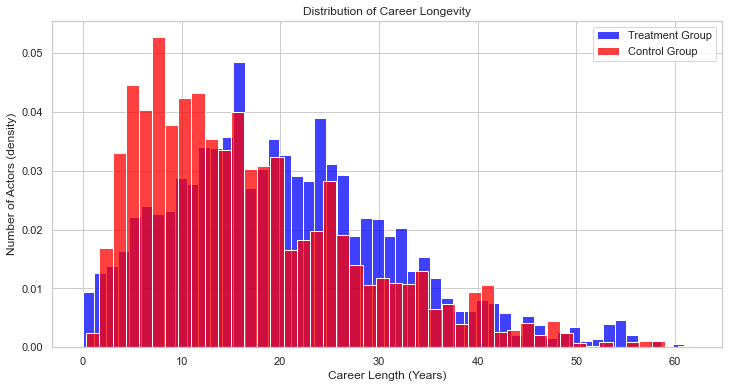

In [ ]:
# Histogram

# Set the style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(treatment_group['career_length_in_years'], color="blue", label='Treatment Group', stat='density')
sns.histplot(control_group['career_length_in_years'], color="red", label='Control Group', stat='density')

plt.title('Distribution of Career Longevity')
plt.xlabel('Career Length (Years)')
plt.ylabel('Number of Actors (density)')
plt.legend()
plt.show()

The control group appears to have more actors in the shorter career span categories (less than 10 years), whereas the treatment group has a more evenly distributed frequency across different career lengths. The treatment group has more actors with longer careers, indicated by the bars extending further to the right (beyond 30 years), compared to the control group. This suggests that actors who have been in a big hit may have longer-lasting careers.

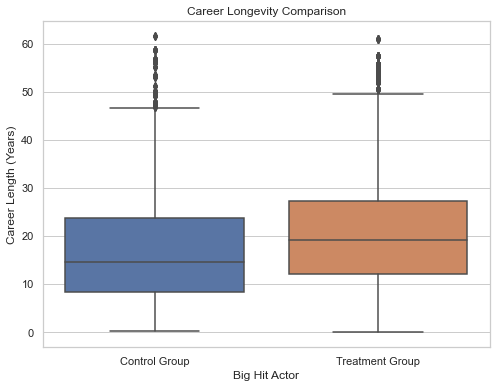

In [ ]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='big_hit_actor', y='career_length_in_years', data=carrer_longevity_df)
plt.title('Career Longevity Comparison')
plt.xlabel('Big Hit Actor')
plt.ylabel('Career Length (Years)')
plt.xticks([0, 1], ['Control Group', 'Treatment Group'])
plt.show()

Comparing the two boxes, we can see that not only is the median of the treatment group higher (indicating longer average career lengths), but the box and whiskers are also generally higher on the scale. This implies that actors in the treatment group not only have a tendency towards longer careers on average but also include more actors with very long careers.

Next, we will look to the number of unique movieIDs associated with each actor to see if actors in big hits tend to appear in more movies overall

In [ ]:

# Calculate the average number of movies for the treatment group
average_movies_treatment = treatment_group['movie_count'].mean()

# Calculate the average number of movies for the control group
average_movies_control = control_group['movie_count'].mean()

print(f'Average number of movies for actors in big hits: {average_movies_treatment}')
print(f'Average number of movies for actors not in big hits: {average_movies_control}')


Average number of movies for actors in big hits: 16.71455213007751
Average number of movies for actors not in big hits: 8.174482983227488


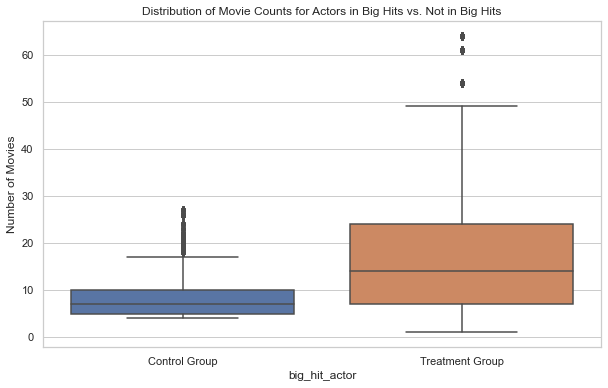

In [ ]:
averages = [average_movies_control, average_movies_treatment]
group_names = ['Control Group', 'Treatment Group']

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='big_hit_actor', y='movie_count', data=carrer_longevity_df)
plt.xticks([0, 1], ['Control Group', 'Treatment Group'])
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Counts for Actors in Big Hits vs. Not in Big Hits')
plt.show()

The treatment group's median is higher than the control group's median, indicating that actors who have played in big hits tend to appear in more movies. 

The treatment group's upper whisker extends farther than the control group's, suggesting that some actors in the treatment group have appeared in a very high number of movies

The treatment group not only has a higher median but also a wider range of movie counts, suggesting that being in a big hit could be associated with a larger number of movie appearances. However, the presence of outliers indicates that there are exceptions to this trend

We want how long it takes to achieve a big hit for the treatment group

In [ ]:
career_start = carrer_longevity_df.groupby('name_actor')['releaseDate'].min().dt.year

career_start_df = career_start.reset_index()
career_start_df.columns = ['name_actor', 'career_start_year']

In [ ]:
merged_df = pd.merge(carrer_longevity_df, career_start_df, on='name_actor')


In [ ]:
merged_df['ethnicity'].isna().sum() / len(merged_df)

0.5448863829353623

In [ ]:
treatment_group= merged_df[merged_df['big_hit_actor']==True]

treatment_group['time_to_first_big_hit'] = treatment_group['year_first_big_hit'] - treatment_group['career_start_year']

print(f"Time to achieve a big hit for a big hit actor: {treatment_group['time_to_first_big_hit'].mean()}")


Time to achieve a big hit for a big hit actor: 3.2667404860423104


/var/folders/f0/cfcxfzqn0nv2yms8q65vtvc80000gn/T/ipykernel_54193/3243738009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_group['time_to_first_big_hit'] = treatment_group['year_first_big_hit'] - treatment_group['career_start_year']


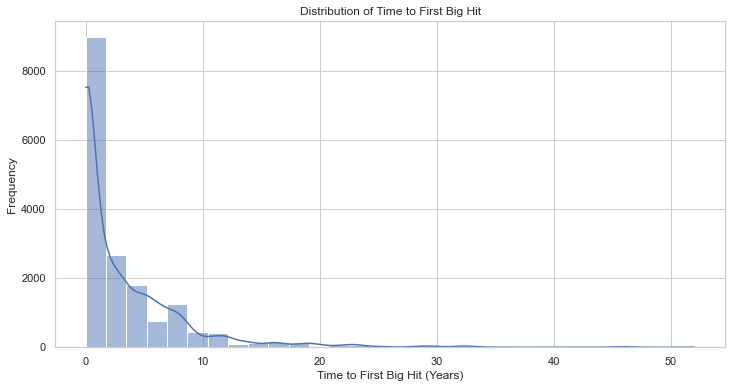

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of time to first big hit
plt.figure(figsize=(12, 6))
sns.histplot(treatment_group['time_to_first_big_hit'], bins=30, kde=True)
plt.title('Distribution of Time to First Big Hit')
plt.xlabel('Time to First Big Hit (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()